In [18]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import preprocessing
import japanize_matplotlib
# LightGBM
import lightgbm as lgb
import optuna
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

In [78]:
#データの読み込み
data_folder = input("データファイルのあるフォルダまでのパス")
data_folder = data_folder.rstrip()
data_folder = data_folder.replace("\\", "/") + "/"
    
file_error = data_folder + "input_errorfiles.csv"
    
file_ok_1 = data_folder + "train_data1.csv"
file_ok_2 = data_folder + "train_labels.csv"

df_ok_1 = pd.read_csv(file_ok_1,encoding="shift-jis")
df_ok_2 = pd.read_csv(file_ok_2,encoding="shift-jis")

df_error = pd.read_csv(file_error,encoding="shift-jis")
df_ok = pd.concat([df_ok_1,df_ok_2],axis = 1)

In [79]:
df_error = df_error.drop(["No","堤外側水位_地震時","堤内側水位_地震時"," 震度"],axis=1)

In [80]:
df_ok = df_ok.drop(["せん断変形破壊","滑動、支持力","根入れ部の安定","遮水効果","矢板の耐力照査","タイロッドの耐力照査","腹起しの耐力照査"],axis=1)

In [82]:
def label_en(label):
    label = label.astype("category")
    le_embarked = LabelEncoder()
    le_embarked.fit(label)
    return le_embarked.transform(label)
#タイプ3:0，タイプ4:1，タイプ5:2
df_ok['矢板型'] = label_en(df_ok['矢板型'])
#SY295:0，SY390:1
df_ok['矢板材料'] = label_en(df_ok['矢板材料'])

df_ok['中詰め区分'] = label_en(df_ok["中詰め区分"])
df_ok['腹起し番号'] = label_en(df_ok["腹起し番号"])
df_ok['引張材材料番号'] = label_en(df_ok["引張材材料番号"])	
df_ok['腹起し材質'] = label_en(df_ok["腹起し材質"])	

#タイプ3:0，タイプ4:1，タイプ5:2
df_error['矢板型'] = label_en(df_error['矢板型'])
#SY295:0，SY390:1
df_error['矢板材料'] = label_en(df_error['矢板材料'])
df_error['中詰め区分'] = label_en(df_error["中詰め区分"])
df_error['腹起し番号'] = label_en(df_error["腹起し番号"])
df_error['引張材材料番号'] = label_en(df_error["引張材材料番号"])	
df_error['腹起し材質'] = label_en(df_error["腹起し材質"])	

In [83]:
df_ok["根入れ深さ"] = df_ok["矢板の全長"] - df_ok["左右壁体高さ"]
df_error["根入れ深さ"] = df_error["矢板の全長"] - df_error["左右壁体高さ"]

In [84]:
# 目的変数の設定
pur = "根入れ深さ"

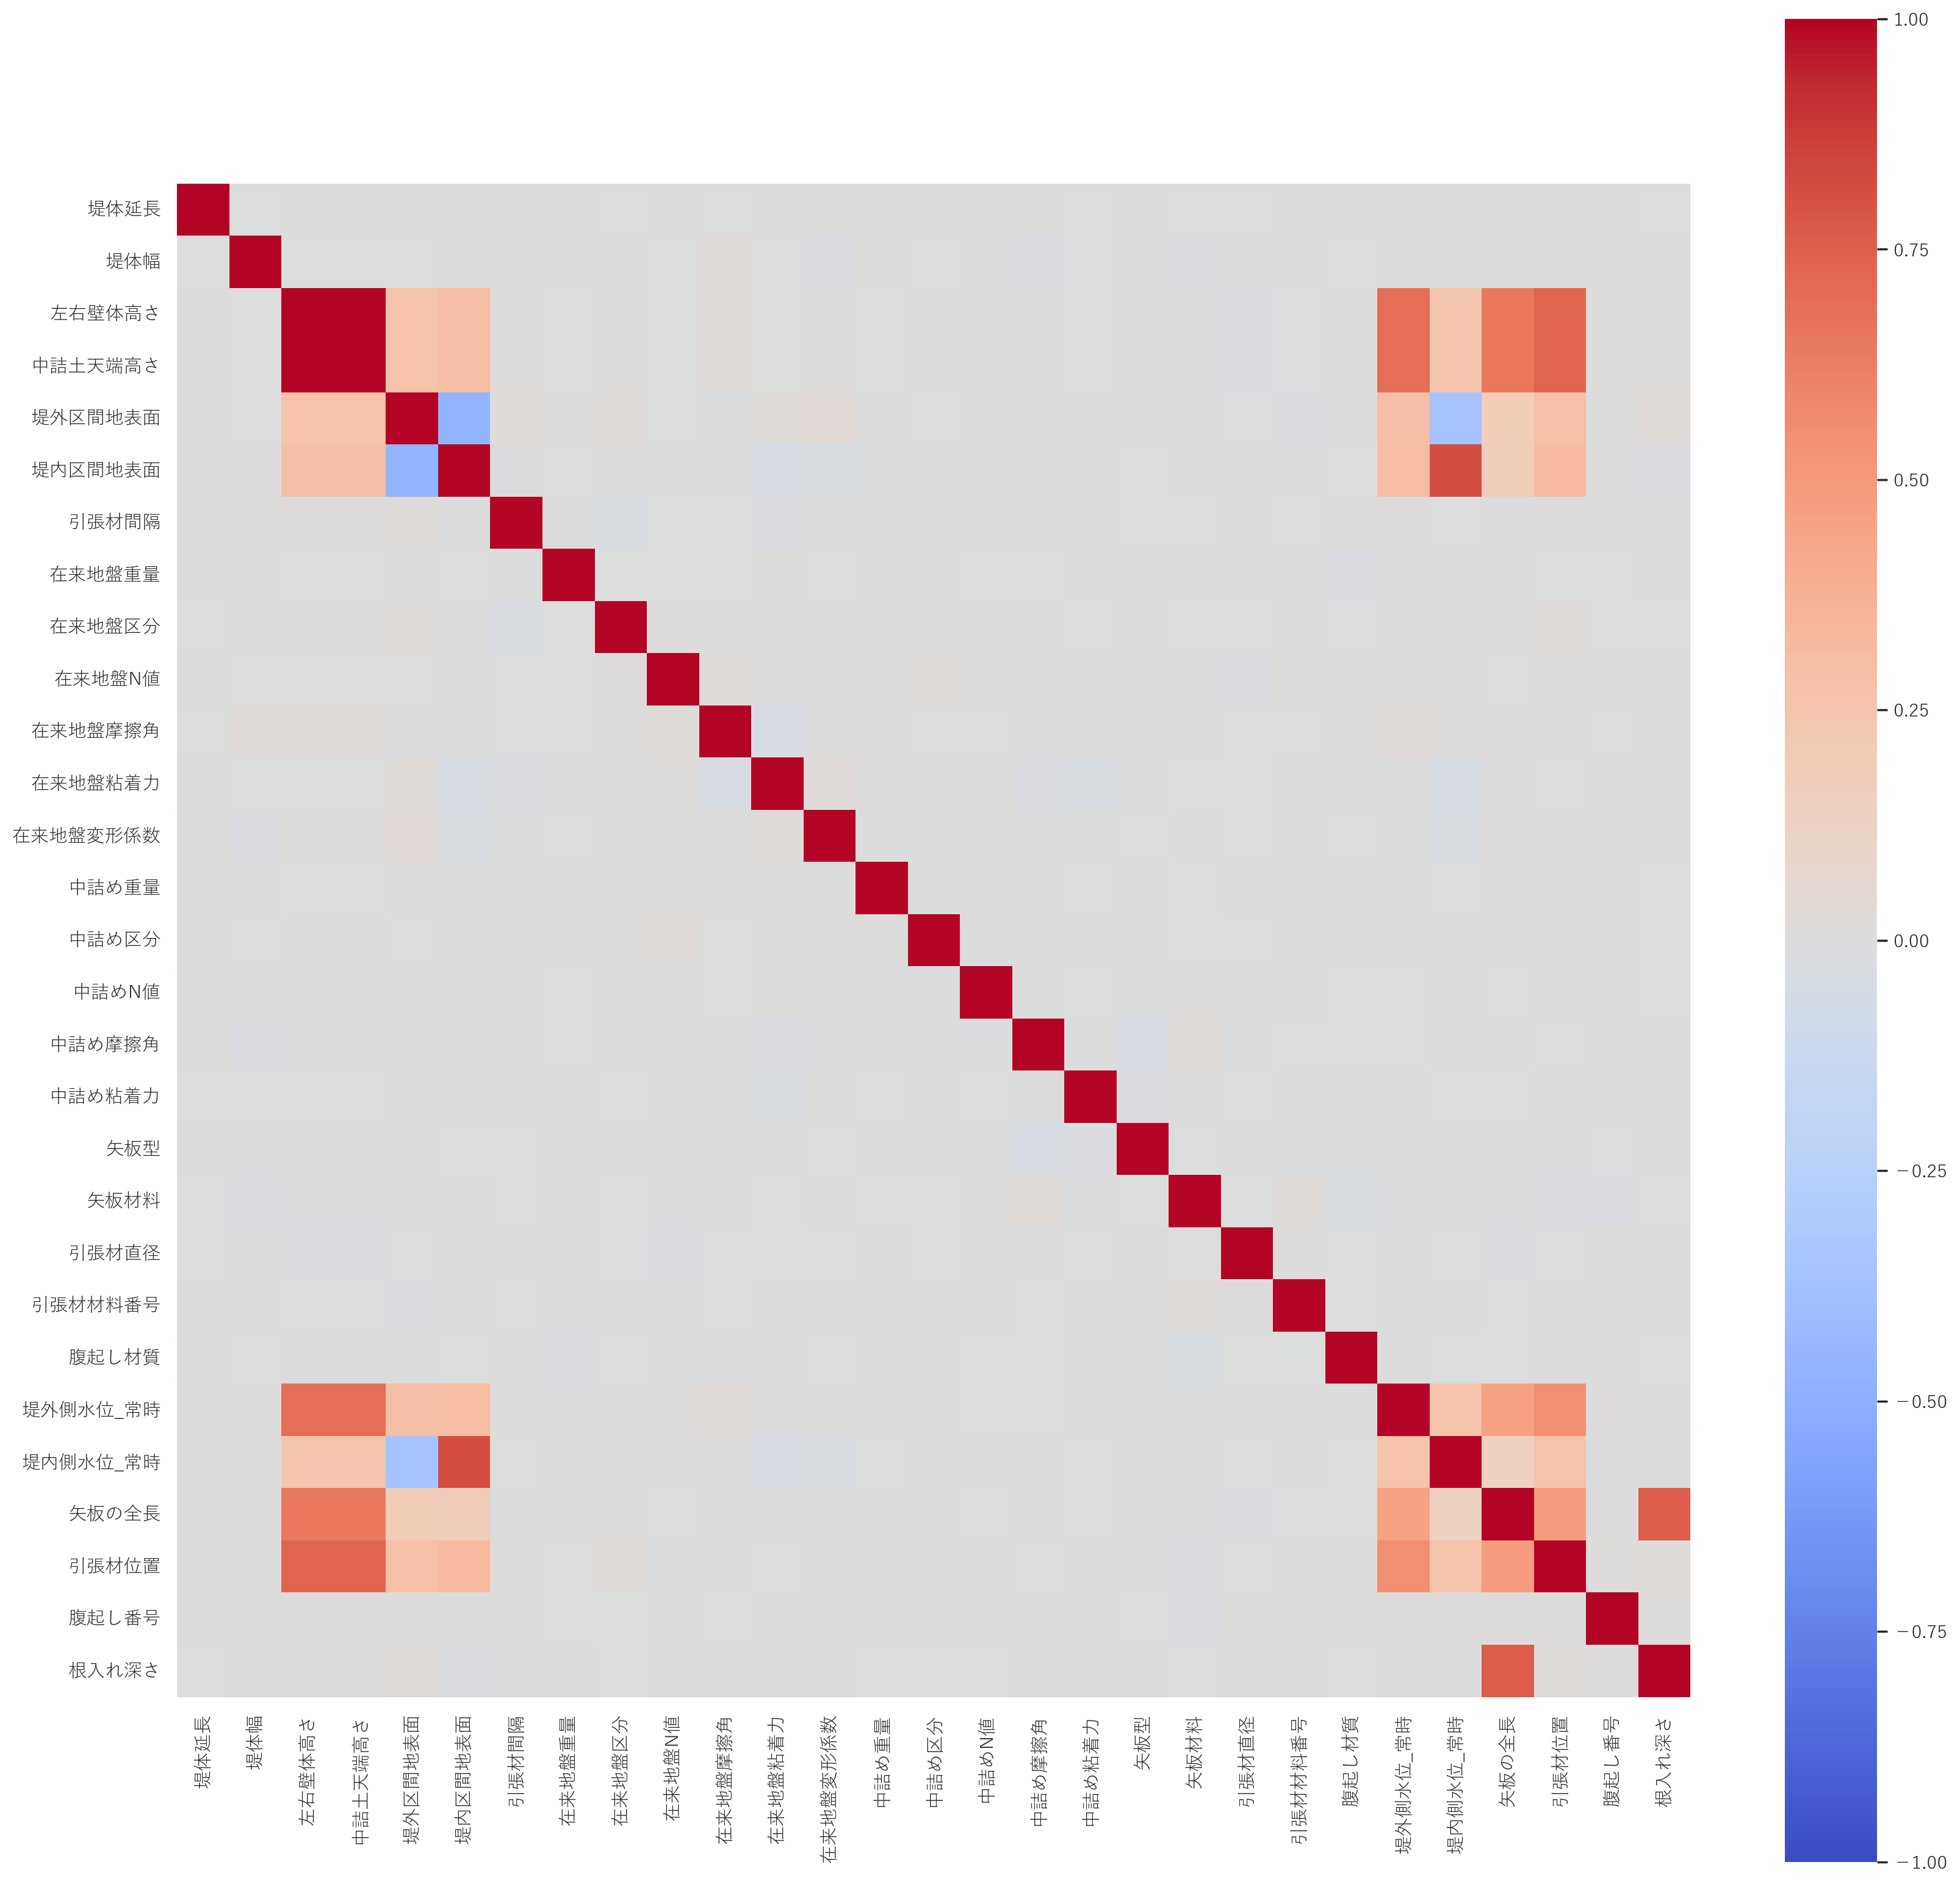

In [56]:
# sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font='Yu Gothic')
plt.figure(figsize=(20,20),dpi=200)
p=sns.heatmap(df_ok.corr(),square=True, vmax=1, vmin=-1, center=0,cmap='coolwarm')

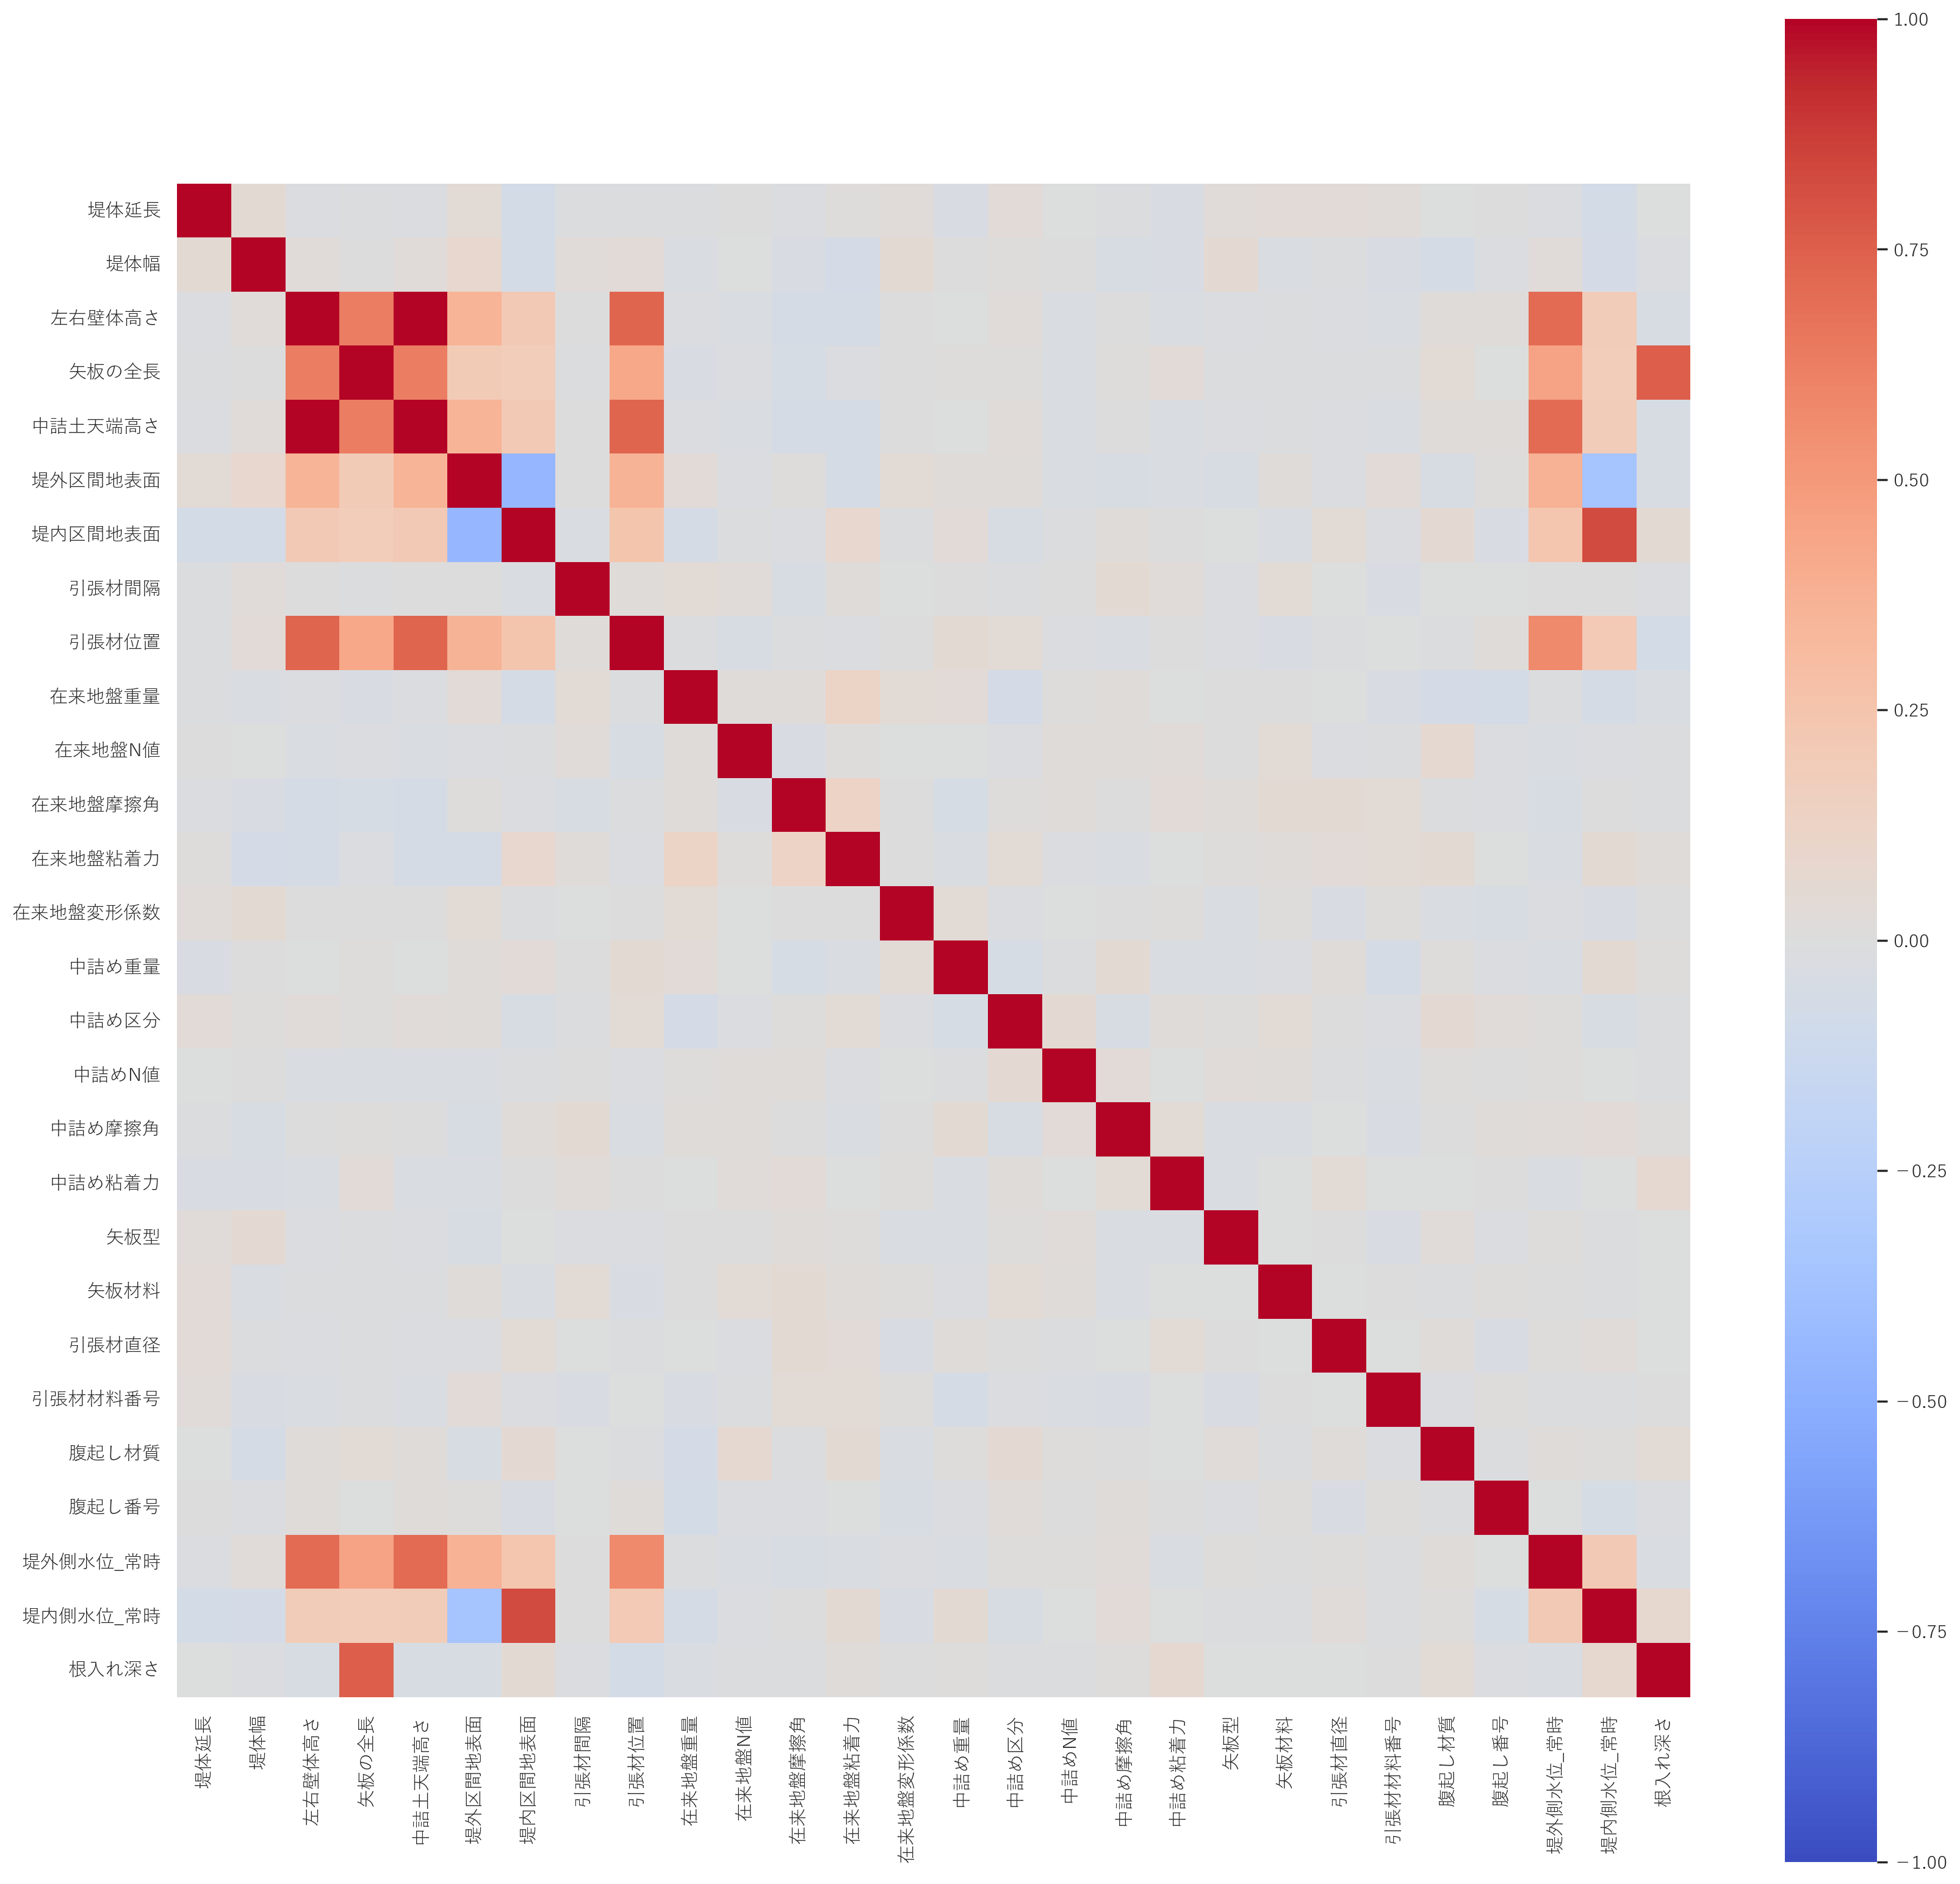

In [57]:
# sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font='Yu Gothic')
plt.figure(figsize=(20,20),dpi=200)
p=sns.heatmap(df_error.corr(),square=True, vmax=1, vmin=-1, center=0,cmap='coolwarm')

In [ ]:
sns.set(font='Yu Gothic',rc = {'figure.figsize':(20,20)})
sns.heatmap(df_ok.corr()[[pur]].sort_values(by=pur, ascending=False)[1:],cmap='coolwarm', annot=True)

In [ ]:
sns.set(font='Yu Gothic',rc = {'figure.figsize':(20,20)})
sns.heatmap(df_error.corr()[[pur]].sort_values(by=pur, ascending=False)[1:],cmap='coolwarm', annot=True)

C:\Users\kmizu\AppData\Local\Temp/ipykernel_33000/3979048770.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 800x1200 with 0 Axes>

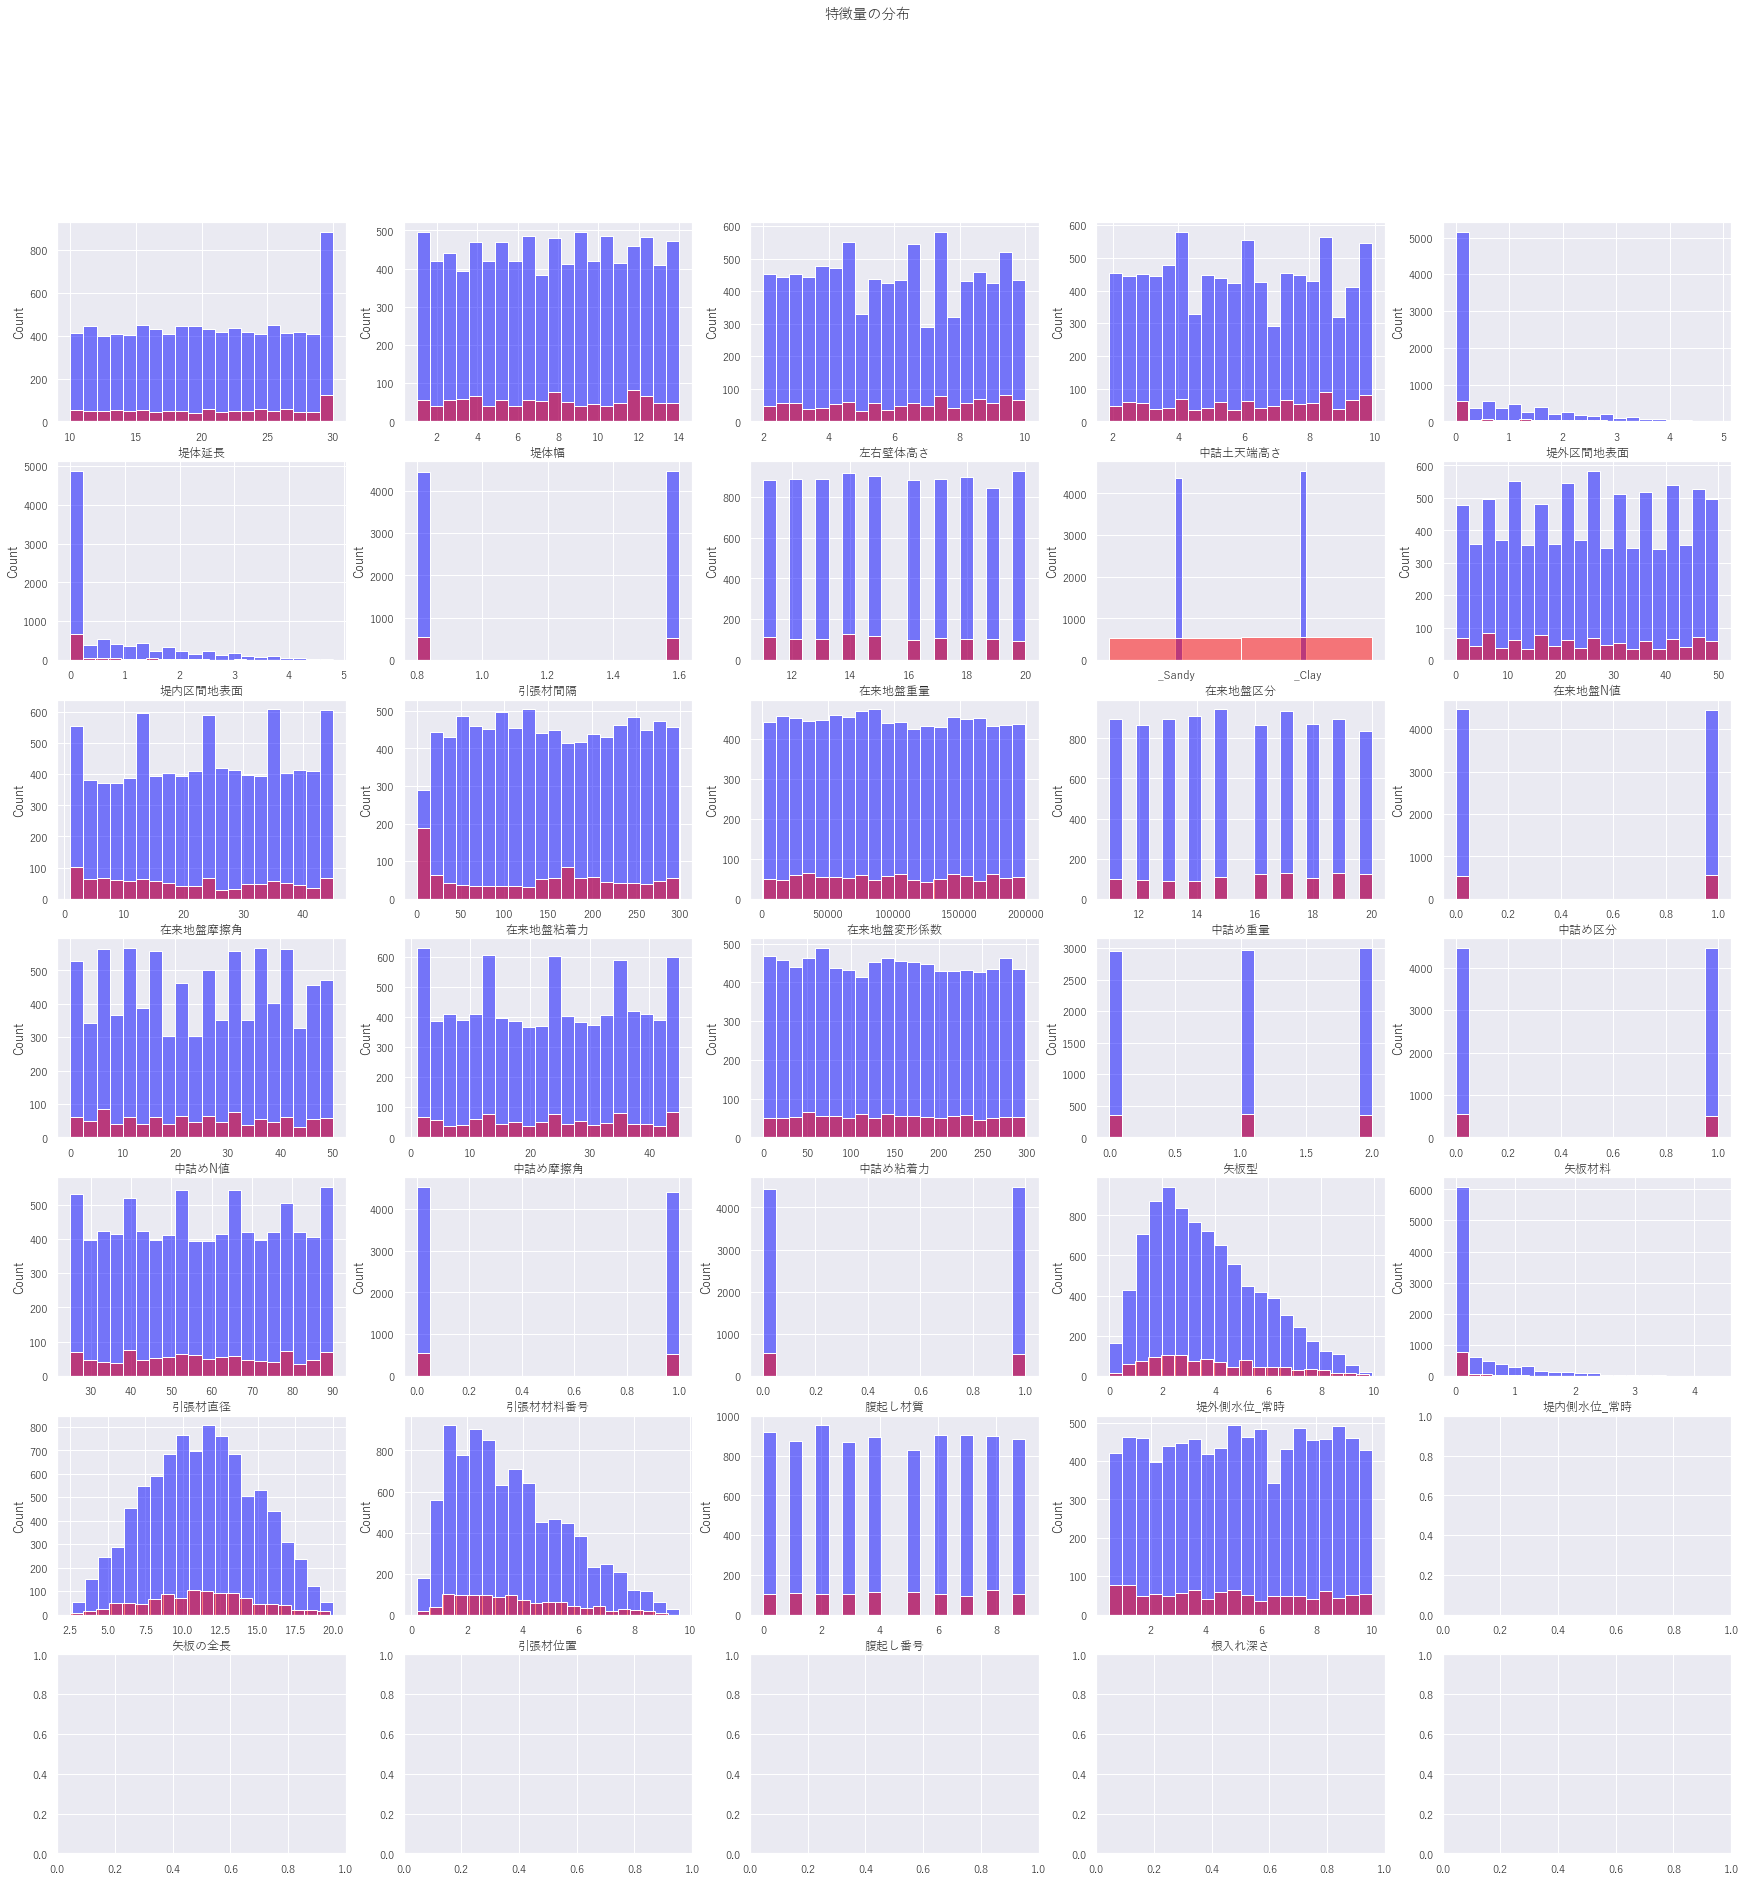

In [85]:
#各特徴量の分布
def plot_histgram(x1,x2, title=None,nrows=2,ncols=2):
    sns.set(font='Yu Gothic',rc = {'figure.figsize':(30,30)})

    cols = x1.columns
    plt.figure(figsize=(4,6),dpi=200)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    
    for ax,c in zip(axes.ravel(),cols):
        sns.histplot(x1[c],alpha = 0.5, bins=20,ax = ax,label="ok",color="blue")
        sns.histplot(x2[c],alpha = 0.5,bins =20,ax=ax, label="error",color="red")
        # fig.suptitle(title)
        # ax.set_xlabel(x_label)
    

    # sns.histplot(x, kde = False, ax=ax)
    # fig.suptitle(title)
    # ax.set_xlabel(x_label)
    
    fig.suptitle(title)
    fig.show()

plot_histgram(df_ok[df_ok.columns],df_error[df_error.columns], title="特徴量の分布", nrows=7, ncols=5)

c:\Users\kmizu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\kmizu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\kmizu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\kmizu\Anacond

<Figure size 4000x4000 with 0 Axes>

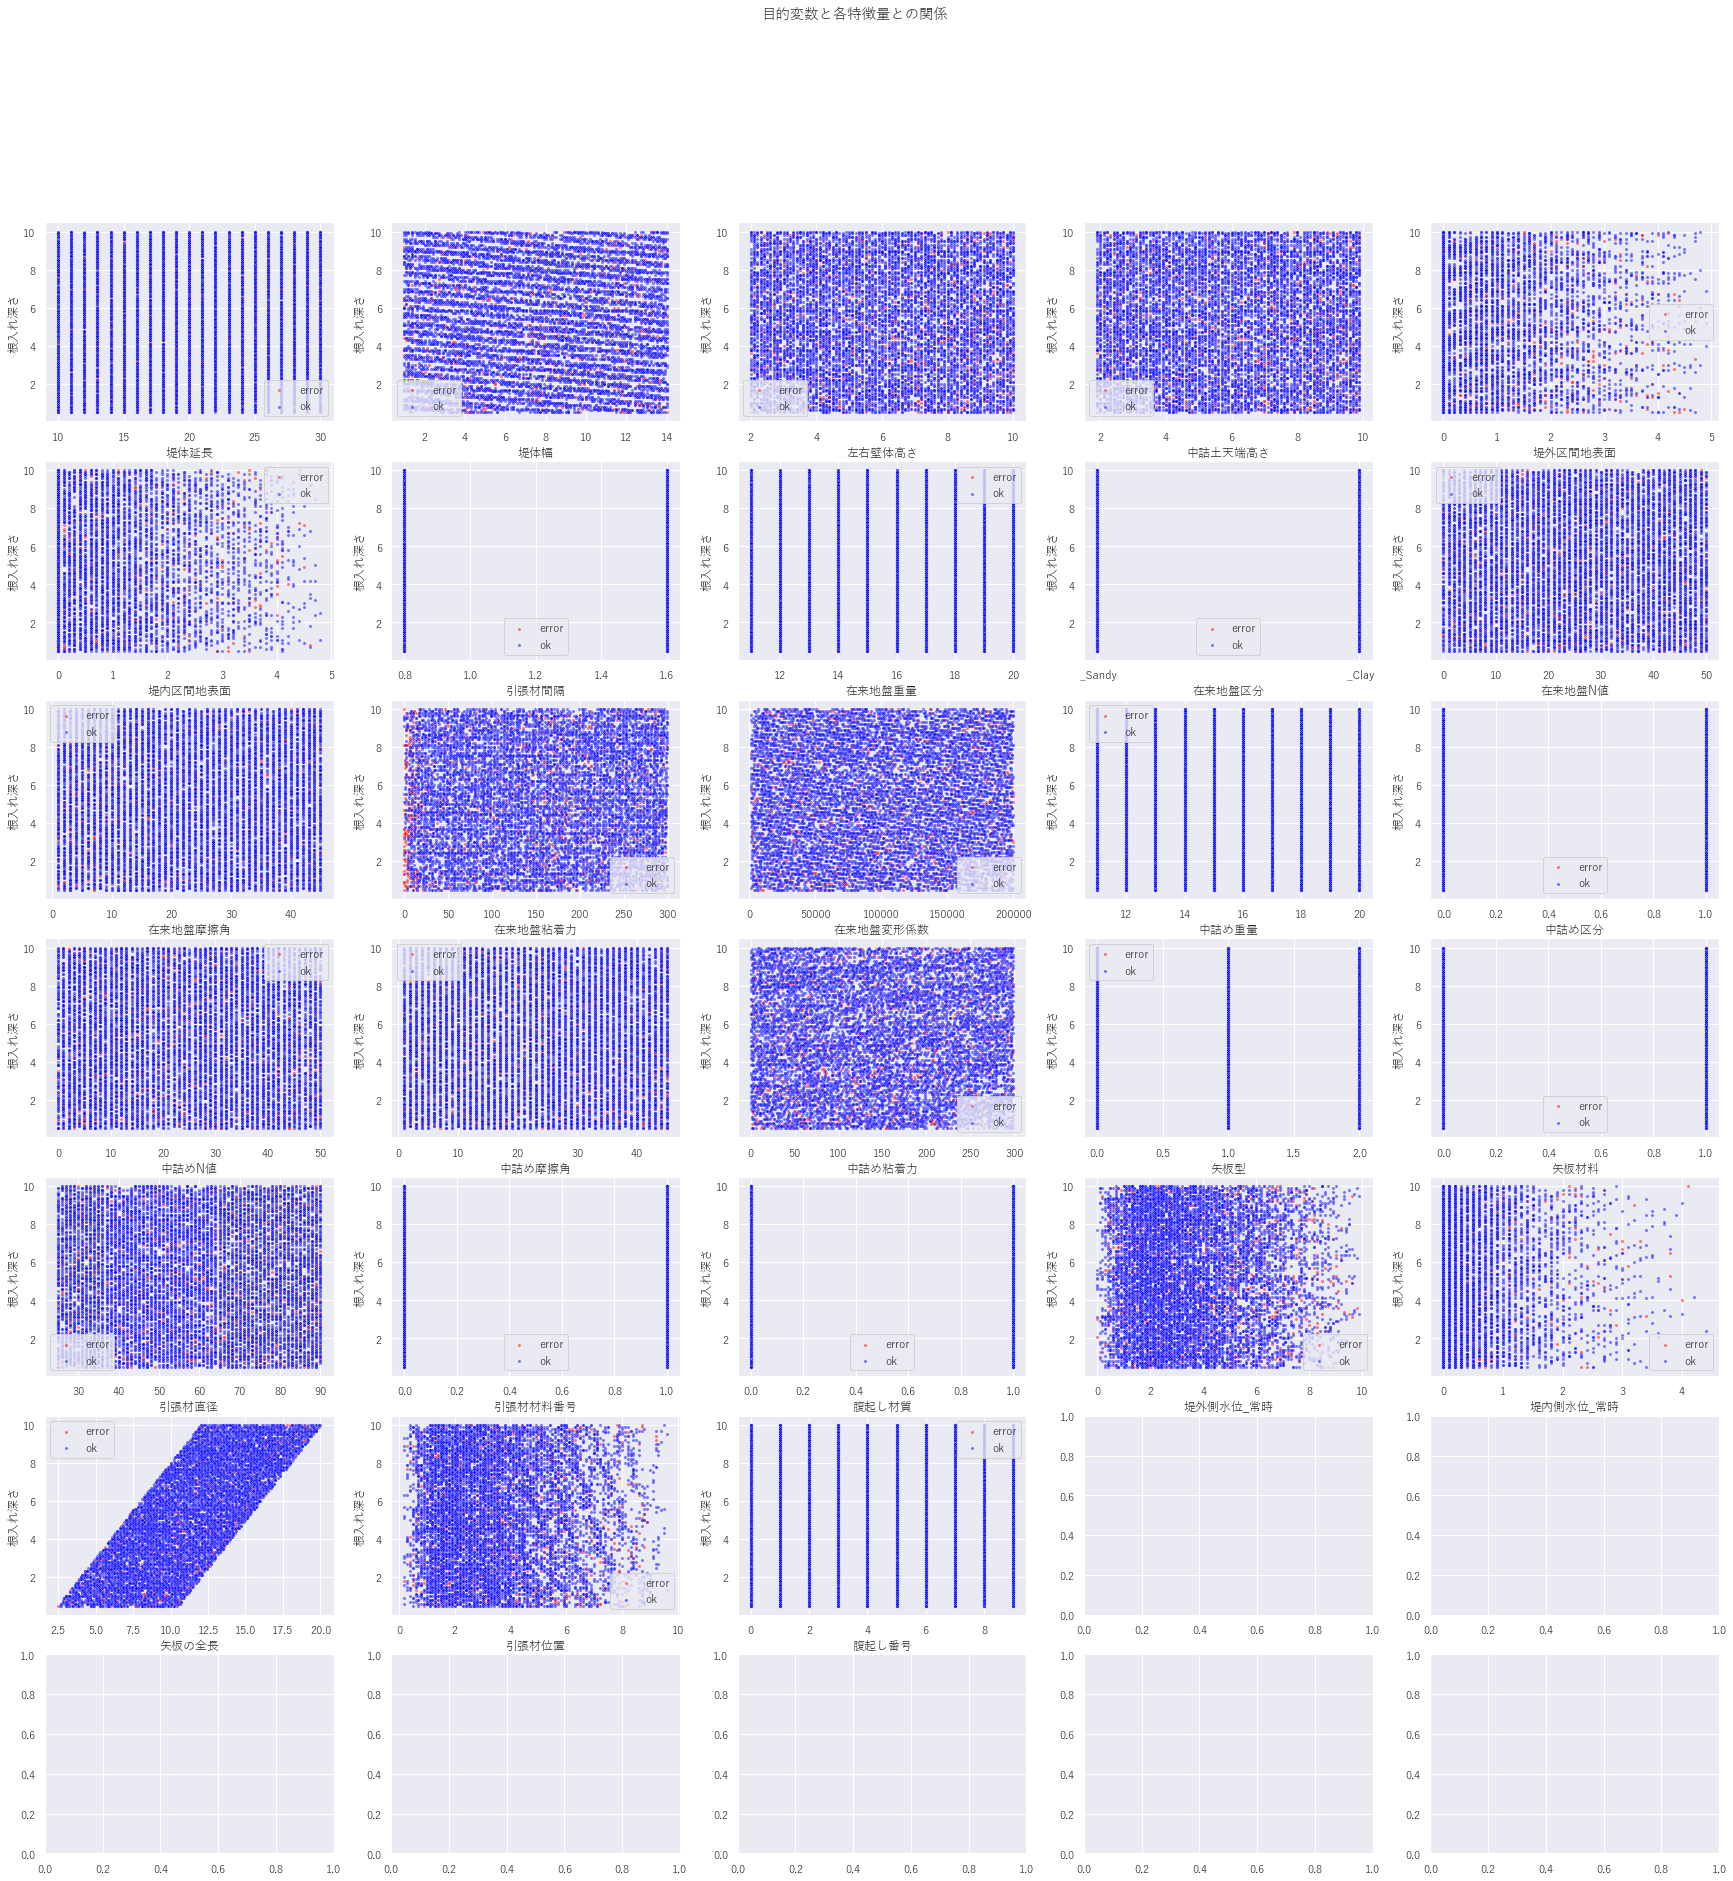

In [86]:
#目的変数と各特徴量の関係
def plt_scatters(X1, y1,X2 ,y2,title = None,nrows=2,ncols=2):
    # sns.set(rc = {'figure.figsize':(15,8)})
    sns.set(font='Yu Gothic',rc = {'figure.figsize':(30,30)})

    cols = X1.columns
    plt.figure(figsize=(4,4),dpi=1000)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    for ax,c in zip(axes.ravel(),cols):
        sns.scatterplot(X2[c], y2 , ci=None, alpha = 0.5, ax = ax,label="error",color="red",s=10)
        sns.scatterplot(X1[c], y1 , ci=None, alpha = 0.5, ax = ax,label="ok",color="blue",s=10)
        ax.set(ylabel = y1.name)
    

    fig.suptitle(title)
    fig.show()

xx_ok = df_ok.drop([pur], axis = 1)
xx_error = df_error.drop([pur], axis = 1)
plt_scatters(
    df_ok[xx_ok.columns],
    df_ok[pur],
    df_error[xx_error.columns],
    df_error[pur],
    title = "目的変数と各特徴量との関係",
    nrows = 7,
    ncols = 5
)